In [1]:
#!/usr/bin/env python3.9
# -*- coding: utf-8 -*-

"""
Author: Letícia Tavares
Date: 2024-08-06
Version: 1.0.0

Description:
    The provided Notebook python script is designed to analyze the performance of various machine 
    learning models applied to different feature groups for genre classification. It begins by importing 
    necessary libraries and setting up configurations. The script defines functions to read and process model 
    results from CSV files, merge them into comprehensive dataframes, and identify the best-performing models 
    based on F1 macro scores. It also includes functions to extract and format model parameters, as well as 
    visualize the results using bar plots. Additionally, the script processes data for all genres and Brazilian 
    genres separately, compares performance across different feature groups, and highlights the best models for further analysis.

"""

# Standard library imports
import ast  # Abstract Syntax Trees for evaluating string representations of Python objects

# Third-party library imports
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations

# Local application/library specific imports
import functions.analysis_functions as analysis_functions  # Custom functions for analysis

# Configure pandas options
pd.options.mode.chained_assignment = None  # Disable chained assignment warnings


## Functions

In [2]:
# Directory containing model output files
folder_input = "02_Output_Kfold_Models"

# Groups of features
group = ["audio","combined", "combined + audio"]

# Order of feature groups
order = ['audio', 'statistical', 'statistical_time', 'explicitness', 
         'tf-idf', 'lda', 'combined', 'combined + audio', 
         'combined (tf-idf + lda)', 'combined (tf-idf + lda) + audio']

# Mapping model names to readable format
dict_column_name = {"extra_trees": "Extra Trees",
                    "neural_network":"Neural Network",
                    "random_forest":"Random Forest",
                    "svc":"SVC",
                    "kneighbors":"kNN",
                    "feature_group": "features"}

In [3]:
def get_dfs_models(type):

    files = ["extra_trees", "neural_network", "random_forest", "svc", "kneighbors"]
    dfs = {}

    for file in files:

        try:
            # Generate variable name based on file name
            var_name = f"df_{file}"

            name_file = f"{folder_input}/{file}_results_{type}.csv"

            # Read CSV into a DataFrame
            dfs[var_name] = pd.read_csv(name_file)
            
            # Use globals() to dynamically create the variable in the global scope
            globals()[var_name] = dfs[var_name]

        except:
            continue

    return dfs

In [4]:
# Function to merge model results into a single dataframe and sort by feature group
def get_df_result(dfs, type="score"):
    df_result = pd.DataFrame()

    for df_name in dfs.keys():
        column_mean = "mean_test_f1_macro"
        df = dfs[df_name]

        # Format parameter strings for the neural network model
        if df_name == "df_neural_network":
            df['params'] = df.apply(
                lambda row: f"{{'dense_sizes': {row['dense_sizes']}, 'dropout_rate': {row['dropout_rate']}, 'epochs': {row['epochs']}, 'batch_size': {row['batch_size']}}}", 
                axis=1)

        df = df[['feature_group', column_mean, 'params']]
        df.params = df.params.str.replace("model__", "")

        df_name = df_name.replace("df_", "").replace("_results", "")
        model_name = dict_column_name[df_name]

        df = df.rename({column_mean: df_name, 'params': f"{model_name}_params"}, axis=1)
        df = df.sort_values(df_name).drop_duplicates("feature_group", keep="first")
        
        if not df_result.empty:
            df_result = df_result.merge(df, on="feature_group")
        else:
            df_result = df.copy()

    # Sort the dataframe by the predefined order of feature groups
    df_result['Order'] = pd.Categorical(df_result['feature_group'], categories=order, ordered=True)
    df_result = df_result.sort_values('Order').drop('Order', axis=1)
    df_result = df_result.rename(dict_column_name, axis=1)
    df_result = df_result.set_index("features")

    # Add a column for the best model score for each feature group
    columns_models = [v for k, v in dict_column_name.items() if v in df_result.columns]
    df_result['Best'] = df_result[columns_models].max(axis=1)

    return df_result

In [5]:
def highlight_max(s):
    # Highlight the maximum value in a Series
    is_max = s == s.max()
    return ['background-color: #21B07A' if v else '' for v in is_max]

In [6]:
def find_best_column(row):
    # Create a boolean mask where values are equal to the value in the Best column
    mask = row == row['Best']
    # Return the name of the column where the mask is true
    return mask[mask].index[0]

# Function to find the corresponding params value
def find_params(row):
    best_column = row['Best_Column']
    params_column = f"{best_column}_params"
    return row[params_column]

def get_best_models(df_result, feats):
    df_result['Best_Column'] = df_result.apply(find_best_column, axis=1)
    df_feats = df_result.loc[feats]
    df_feats['params'] = df_feats.apply(find_params, axis=1)
    df_feats['Model'] = df_feats['Best_Column'] + ' : ' + df_feats['params']
    df_feats = df_feats[["Best", "Model"]]

    return df_feats

def extract_value(dict_str, keys):
    values = ""
    dict_str = ast.literal_eval(dict_str)

    for key in keys:
        if key in dict_str:
            values += ("; " + str(dict_str[key]))
    
    values = values[2:] if values.startswith("; ") else s
    return values

def get_df_params(df_result):
    columns_params = [v + "_params" for v in dict_column_name.values()]
    columns_params.remove("features_params")

    df_params = df_result[columns_params]
    df_params.columns = [c.replace("_params", "") for c in df_params.columns]
    df_params['Extra Trees'] = df_params['Extra Trees'].apply(lambda x: extract_value(x, ['n_estimators']))
    df_params['Random Forest'] = df_params['Random Forest'].apply(lambda x: extract_value(x, ['n_estimators']))
    df_params['Neural Network'] = df_params['Neural Network'].apply(lambda x: extract_value(x, ['dense_sizes']))
    df_params['SVC'] = df_params['SVC'].apply(lambda x: extract_value(x, ['estimator__C']))
    df_params['kNN'] = df_params['kNN'].apply(lambda x: extract_value(x, ['n_neighbors', 'p']))

    return df_params

## Data

In [7]:
df, all_genres, br_genres = analysis_functions.get_data(folder = "")

# Prepare dataframes for all genres and BR genres
df_all_genres = analysis_functions.make_df_genres(df, all_genres)
df_br_genres = analysis_functions.make_df_genres(df, br_genres)

In [8]:
print(f"BASE ALL GENRES")
print(f"Número de Linhas: {len(df_all_genres)}")
display(df_all_genres.sum().to_frame(name='Count').sort_values("Count", ascending=False))

BASE ALL GENRES
Número de Linhas: 19925


,Count
mpb,5000.0
rock,3827.0
sertanejo,3388.0
gospel,2467.0
samba,1570.0
pop,1330.0
pagode,1215.0
bossanova,914.0
alternativo,114.0
indie,100.0


In [9]:
print(f"BASE BR GENRES")
print(f"Número de Linhas: {len(df_br_genres)}")
display(df_br_genres.sum().to_frame(name='Count').sort_values("Count", ascending=False))

BASE BR GENRES
Número de Linhas: 14968


,Count
mpb,6215.0
sertanejo,3407.0
gospel,2467.0
samba,1660.0
pagode,1219.0


## F1 Macro

In [10]:
df_comp = pd.DataFrame()

In [11]:
columns_params = [v + "_params" for v in dict_column_name.values()]
columns_params.remove("features_params")

### All Genres

In [12]:
dfs = get_dfs_models("F1_all_genres")
df_result = get_df_result(dfs, "f1_macro")

# df_params = get_df_params(df_result)
# df_params.to_csv("best_models_params_all_genres.csv")

df_feats = get_best_models(df_result, group)
df_feats = df_feats.rename({"Best": "All_Genres_Best_Score",
                            "Model": "All_Genres_Best_Model"}, axis=1)

df_comp = pd.concat([df_comp, df_feats], axis = 1)

df_result = df_result.select_dtypes(include=[np.number])
styled_df = df_result.style.apply(highlight_max, axis=1)
display(styled_df)
# display(df_params)

,Extra Trees,Neural Network,Random Forest,SVC,kNN,Best
features,,,,,,
audio,0.349565,0.334717,0.355958,0.210121,0.342479,0.355958
statistical,0.226072,0.205951,0.222345,0.152358,0.211807,0.226072
statistical_time,0.133753,0.116017,0.136548,0.081658,0.136755,0.136755
explicitness,0.045206,0.045075,0.045206,0.045206,0.032534,0.045206
tf-idf,0.079089,0.106930,0.075168,0.095943,0.059313,0.106930
lda,0.095874,0.041327,0.097616,0.045449,0.099512,0.099512
combined,0.238235,0.214327,0.236397,0.167408,0.217835,0.238235
combined + audio,0.342942,0.382097,0.355230,0.271468,0.319841,0.382097
combined (tf-idf + lda),0.164703,0.137459,0.173755,0.137389,0.061532,0.173755


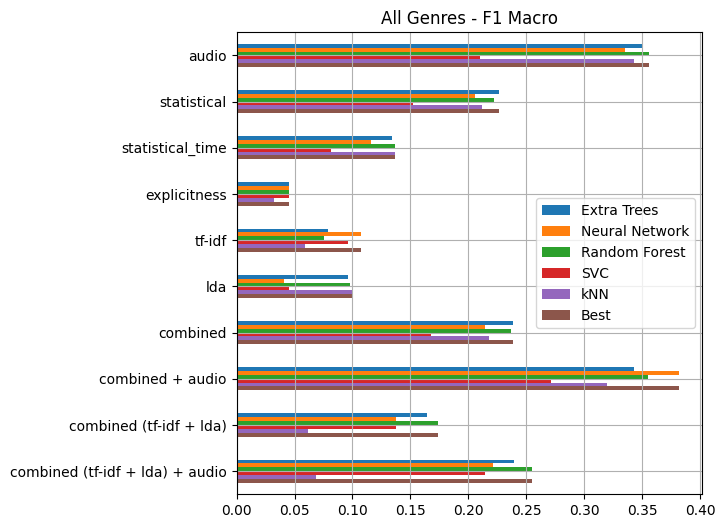

In [13]:
ax = df_result.plot.barh(
    title='All Genres - F1 Macro',
    grid=True,
    figsize=(6, 6),
)
ax.set_ylabel('')
ax.invert_yaxis()

# plt.savefig('', bbox_inches='tight')

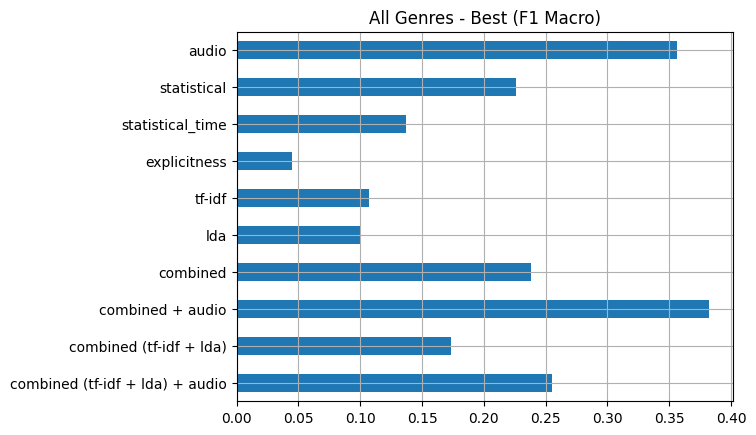

In [14]:
best_score = df_result.max(axis=1)

ax = best_score.plot.barh(
    title='All Genres - Best (F1 Macro)',
    grid=True,
)
ax.set_ylabel('')
ax.invert_yaxis()

# plt.savefig('', bbox_inches='tight')

### More Feats All

In [15]:
dfs.keys()

dict_keys(['df_extra_trees', 'df_neural_network', 'df_random_forest', 'df_svc', 'df_kneighbors'])

In [16]:
dfs = get_dfs_models("F1_all_genres_more_feats")
df_result = get_df_result(dfs, "f1_macro")

# df_params = get_df_params(df_result)

df_feats = get_best_models(df_result, group)
df_feats = df_feats.rename({"Best": "All_Genres_Feat_Selec_Best_Score",
                            "Model": "All_Genres_Feat_Selec_Best_Model"}, axis=1)

df_comp = pd.concat([df_comp, df_feats], axis = 1)

df_result = df_result.select_dtypes(include=[np.number])
styled_df = df_result.style.apply(highlight_max, axis=1)
display(styled_df)
# display(df_params)

,Extra Trees,Neural Network,Random Forest,SVC,kNN,Best
features,,,,,,
audio,0.352115,0.332820,0.355958,0.210121,0.342479,0.355958
statistical,0.224853,0.199477,0.222345,0.152358,0.211833,0.224853
statistical_time,0.132521,0.113303,0.136548,0.081658,0.136755,0.136755
explicitness,0.045206,0.045075,0.045206,0.045206,0.034806,0.045206
combined,0.278824,0.294002,0.272105,0.218547,0.274486,0.294002
combined + audio,0.340658,0.411293,0.358452,0.315820,0.331177,0.411293
afinn,0.107611,0.074469,0.108476,0.074989,0.112889,0.112889
vader,0.120291,0.076741,0.123089,0.073006,0.119490,0.123089
lemma,0.124613,0.073252,0.128732,0.055930,0.127911,0.128732


In [17]:
df_result.iloc[4:12]

,Extra Trees,Neural Network,Random Forest,SVC,kNN,Best
features,,,,,,
combined,0.278824,0.294002,0.272105,0.218547,0.274486,0.294002
combined + audio,0.340658,0.411293,0.358452,0.315820,0.331177,0.411293
afinn,0.107611,0.074469,0.108476,0.074989,0.112889,0.112889
vader,0.120291,0.076741,0.123089,0.073006,0.119490,0.123089
lemma,0.124613,0.073252,0.128732,0.055930,0.127911,0.128732
pronouns,0.160206,0.117635,0.162109,0.082347,0.162551,0.162551
postags,0.181029,0.144430,0.178642,0.111263,0.177932,0.181029
rid,0.228466,0.165050,0.223891,0.149727,0.206541,0.228466


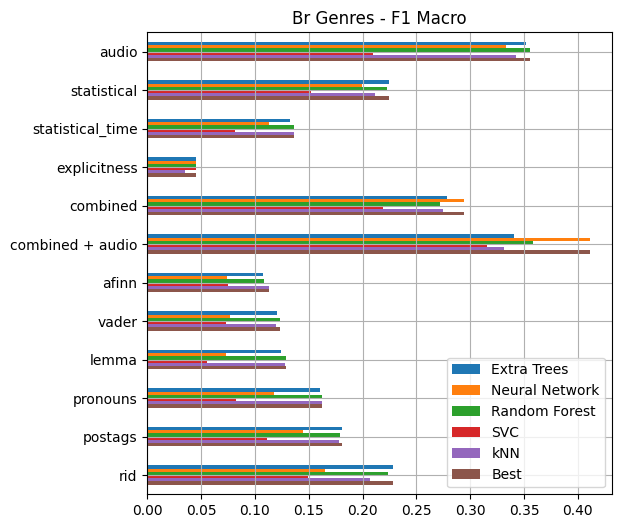

In [18]:
ax = df_result.plot.barh(
    title='Br Genres - F1 Macro',
    grid=True,
    figsize=(6, 6),
)
ax.set_ylabel('')
ax.invert_yaxis()

# plt.savefig('', bbox_inches='tight')

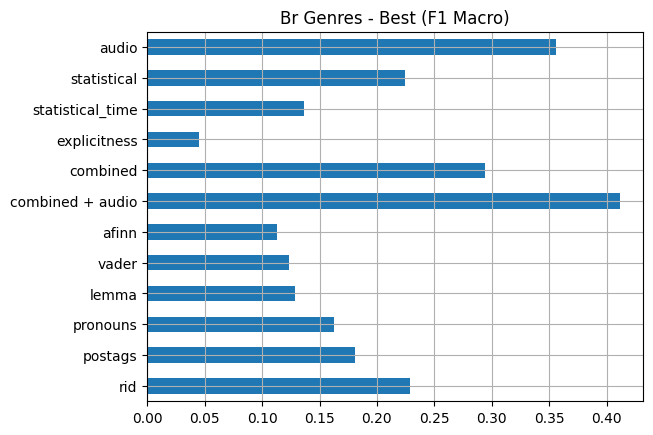

In [19]:
best_score = df_result.max(axis=1)

ax = best_score.plot.barh(
    title='Br Genres - Best (F1 Macro)',
    grid=True,
)
ax.set_ylabel('')
ax.invert_yaxis()

# plt.savefig('', bbox_inches='tight')

### More Feats Br

In [20]:
df_result

,Extra Trees,Neural Network,Random Forest,SVC,kNN,Best
features,,,,,,
audio,0.352115,0.332820,0.355958,0.210121,0.342479,0.355958
statistical,0.224853,0.199477,0.222345,0.152358,0.211833,0.224853
statistical_time,0.132521,0.113303,0.136548,0.081658,0.136755,0.136755
explicitness,0.045206,0.045075,0.045206,0.045206,0.034806,0.045206
combined,0.278824,0.294002,0.272105,0.218547,0.274486,0.294002
combined + audio,0.340658,0.411293,0.358452,0.315820,0.331177,0.411293
afinn,0.107611,0.074469,0.108476,0.074989,0.112889,0.112889
vader,0.120291,0.076741,0.123089,0.073006,0.119490,0.123089
lemma,0.124613,0.073252,0.128732,0.055930,0.127911,0.128732


In [21]:
dfs = get_dfs_models("F1_br_genres_more_feats")
df_result = get_df_result(dfs, "f1_macro")
df_feats = get_best_models(df_result, group)
df_feats = df_feats.rename({"Best": "Br_Genres_Feat_Selec_Best_Score",
                            "Model": "Br_Genres_Feat_Selec_Best_Model"}, axis=1)

# df_params = get_df_params(df_result)

df_comp = pd.concat([df_comp, df_feats], axis = 1)

df_result = df_result.select_dtypes(include=[np.number])
styled_df = df_result.style.apply(highlight_max, axis=1)
display(styled_df)
# display(df_params)

,Extra Trees,Neural Network,Random Forest,SVC,kNN,Best
features,,,,,,
audio,0.531879,0.517338,0.546964,0.358903,0.506789,0.546964
statistical,0.339507,0.356261,0.341228,0.262410,0.340320,0.356261
statistical_time,0.236574,0.210371,0.237965,0.157641,0.244025,0.244025
explicitness,0.117352,0.117349,0.117352,0.117352,0.086192,0.117352
combined,0.393937,0.477783,0.395928,0.379876,0.422787,0.477783
combined + audio,0.477509,0.606111,0.539489,0.507784,0.490384,0.606111
afinn,0.210622,0.126017,0.212999,0.136134,0.216917,0.216917
vader,0.220717,0.117349,0.227884,0.117352,0.218585,0.227884
lemma,0.226773,0.118365,0.228475,0.117966,0.225990,0.228475


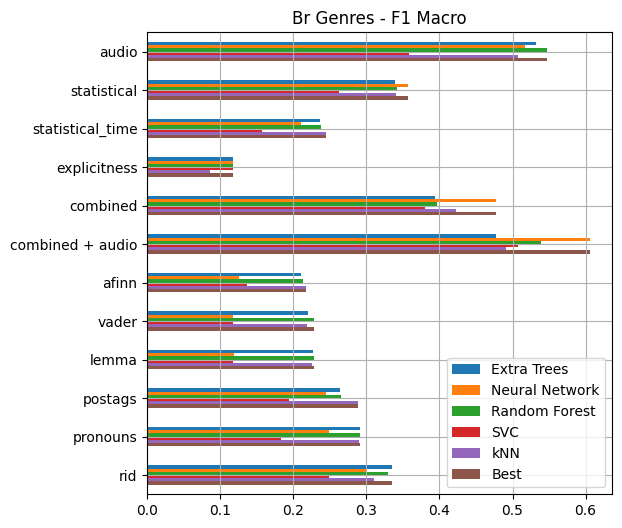

In [22]:
ax = df_result.plot.barh(
    title='Br Genres - F1 Macro',
    grid=True,
    figsize=(6, 6),
)
ax.set_ylabel('')
ax.invert_yaxis()

# plt.savefig('', bbox_inches='tight')

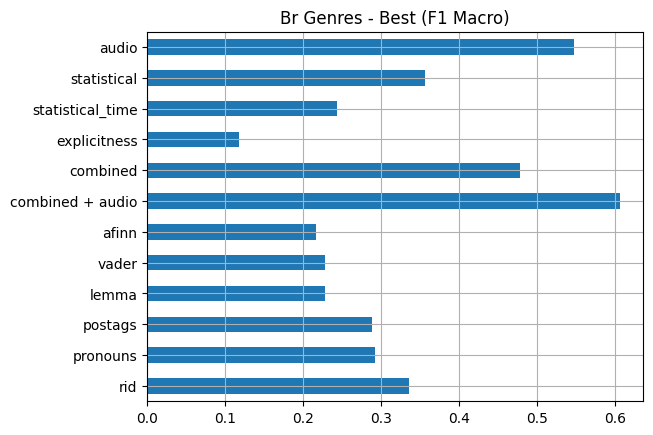

In [23]:
best_score = df_result.max(axis=1)

ax = best_score.plot.barh(
    title='Br Genres - Best (F1 Macro)',
    grid=True,
)
ax.set_ylabel('')
ax.invert_yaxis()

# plt.savefig('', bbox_inches='tight')

### Comparison

In [24]:
df_comp

,All_Genres_Best_Score,All_Genres_Best_Model,All_Genres_Feat_Selec_Best_Score,All_Genres_Feat_Selec_Best_Model,Br_Genres_Feat_Selec_Best_Score,Br_Genres_Feat_Selec_Best_Model
features,,,,,,
audio,0.355958,Random Forest : {'n_estimators': 300},0.355958,Random Forest : {'n_estimators': 300},0.546964,Random Forest : {'n_estimators': 300}
combined,0.238235,Extra Trees : {'n_estimators': 300},0.294002,"Neural Network : {'dense_sizes': (64, 64), 'dr...",0.477783,"Neural Network : {'dense_sizes': (64, 64), 'dr..."
combined + audio,0.382097,"Neural Network : {'dense_sizes': (64, 64), 'dr...",0.411293,"Neural Network : {'dense_sizes': (64, 64), 'dr...",0.606111,"Neural Network : {'dense_sizes': (64, 64), 'dr..."
